# Import df

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [95]:
df = pd.read_parquet('../data/cleanedData/allData.parquet')
df.set_index('measurementDate', inplace=True)

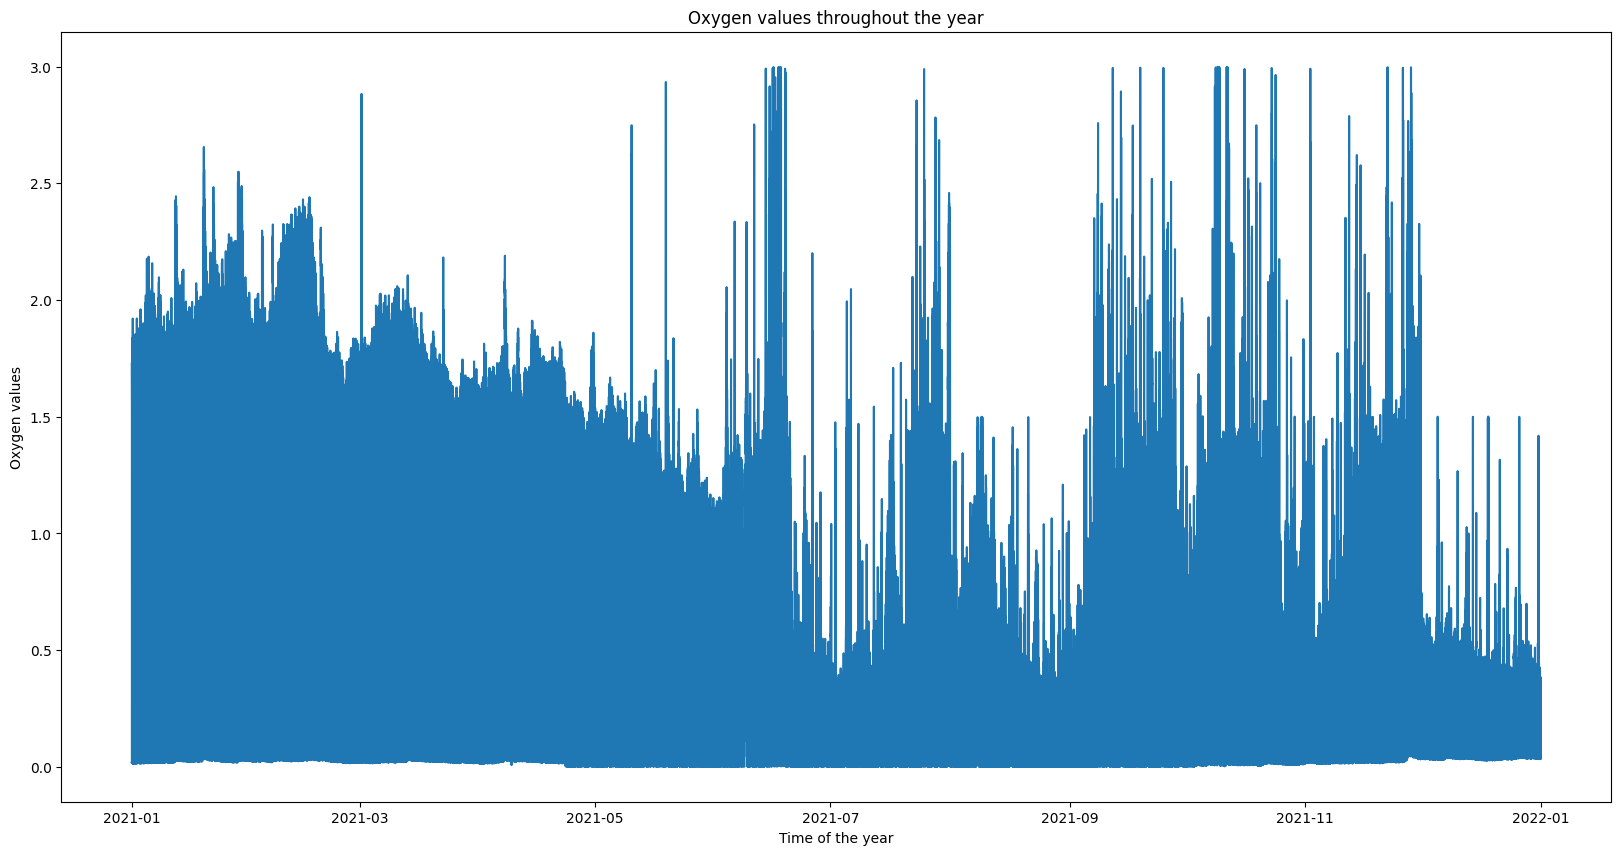

In [96]:
plt.figure(figsize=(20,10))
plt.plot(df.index, df['oxygenValue'])
plt.title("Oxygen values throughout the year")
plt.xlabel("Time of the year")
plt.ylabel("Oxygen values")
plt.show()

# ! Time test Split !

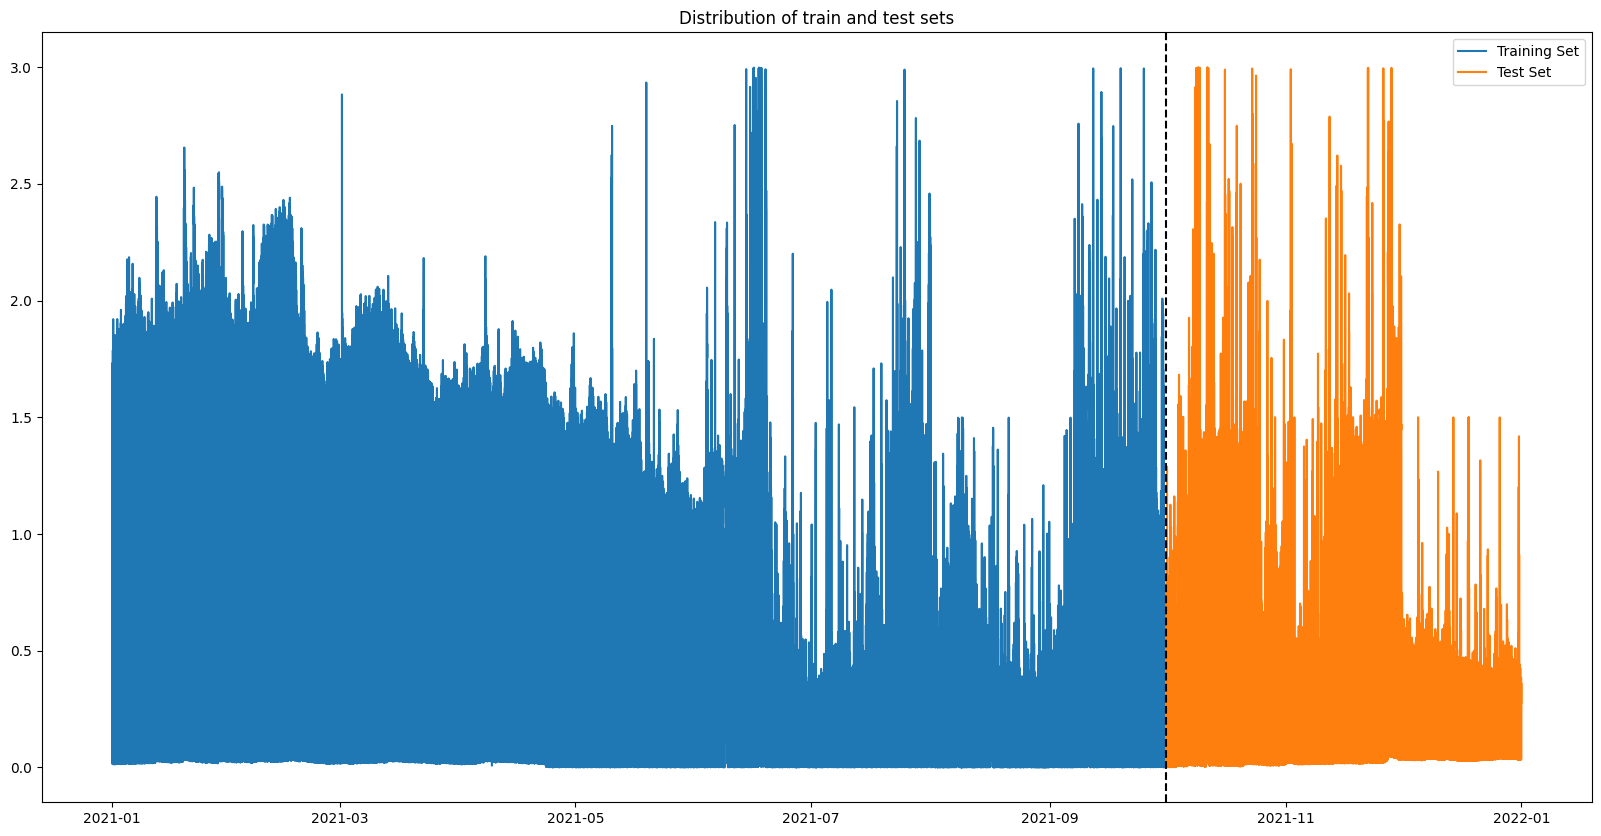

In [97]:
train = df.loc[df.index<'2021-10-01']
test = df.loc[df.index>='2021-10-01']

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train.index,train['oxygenValue'])
plt.plot(test.index,test['oxygenValue'])
ax.axvline(pd.to_datetime('2021-10-01'),color='black', ls='--')
plt.title("Distribution of train and test sets")
plt.legend(['Training Set','Test Set'])
plt.show()

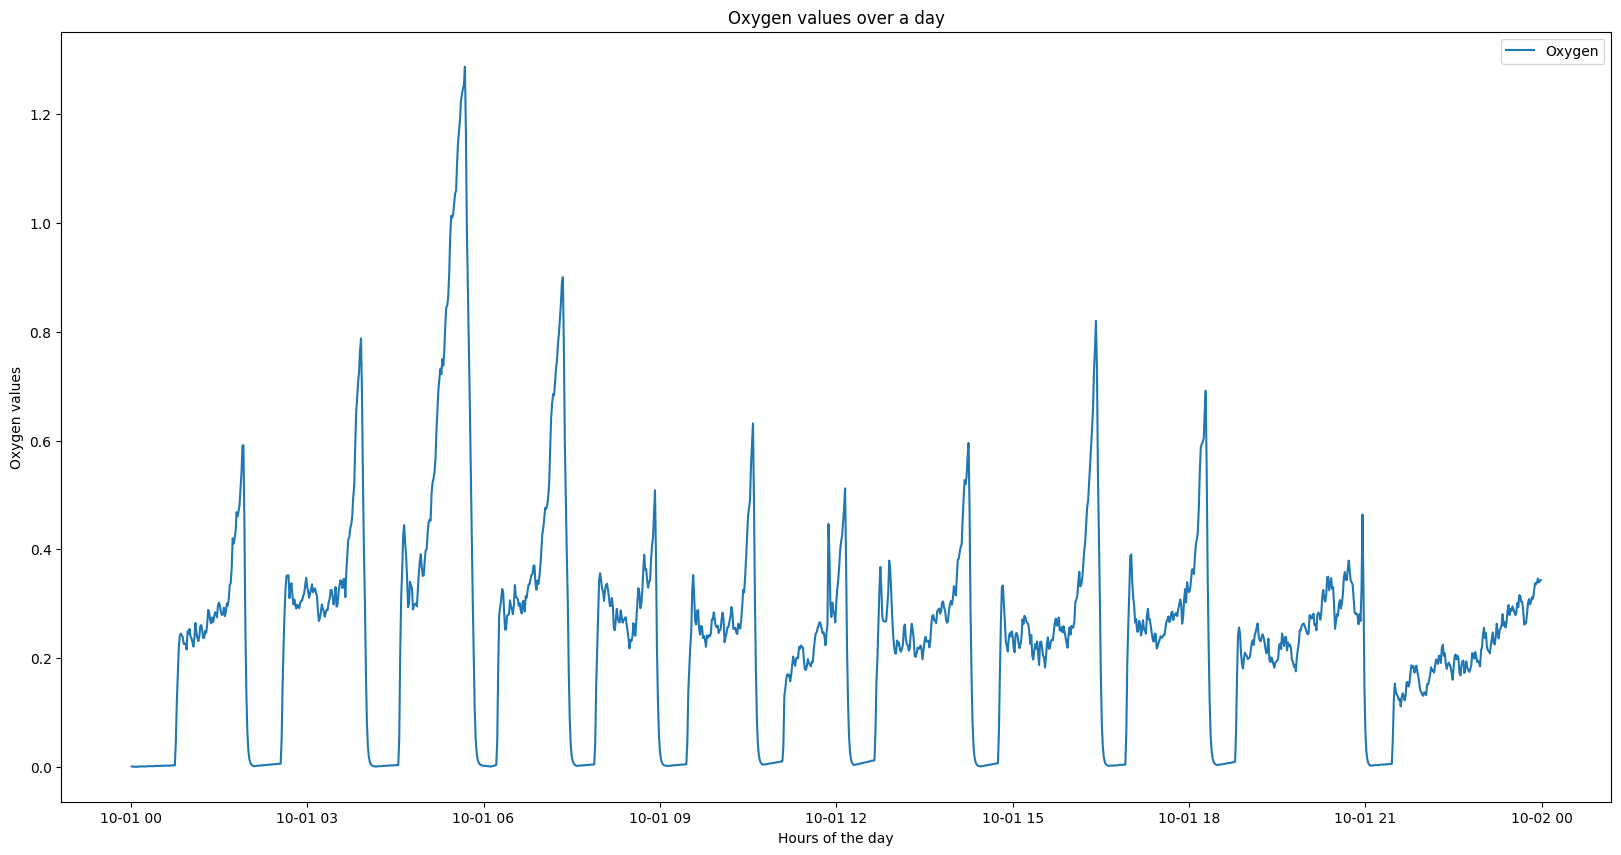

In [98]:
day = df.loc[(df.index > '2021-10-01') & (df.index < '2021-10-02')]

plt.figure(figsize=(20,10))
plt.title("Oxygen values over a day")
plt.plot(day.index,day['oxygenValue'])
plt.xlabel('Hours of the day')
plt.ylabel('Oxygen values')
plt.legend(["Oxygen"])

# Feature Creation

In [99]:
def create_features(df):
    df = df.copy()
    df['minute'] =df.index.minute
    df['hour'] = df.index.hour
    df['dayofweek']=df.index.dayofweek
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    return df

df = create_features(df)

Text(0, 0.5, 'Value of oxygen')

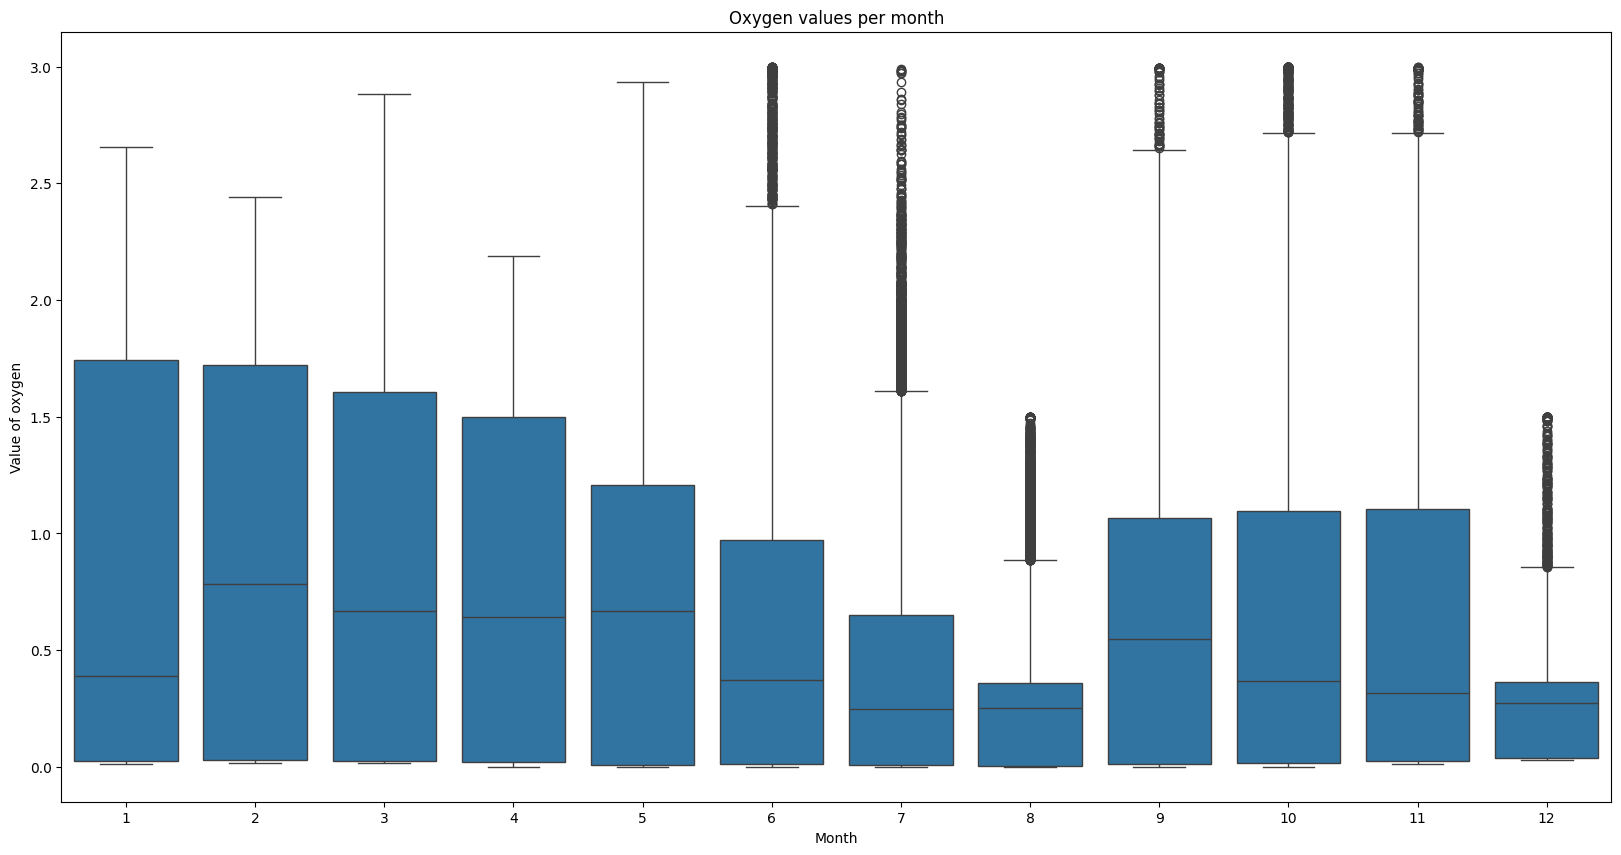

In [100]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df,x='month',y='oxygenValue')
plt.title('Oxygen values per month')
plt.xlabel("Month")
plt.ylabel("Value of oxygen")

# Distribution across periods

Text(0, 0.5, 'Value of oxygen')

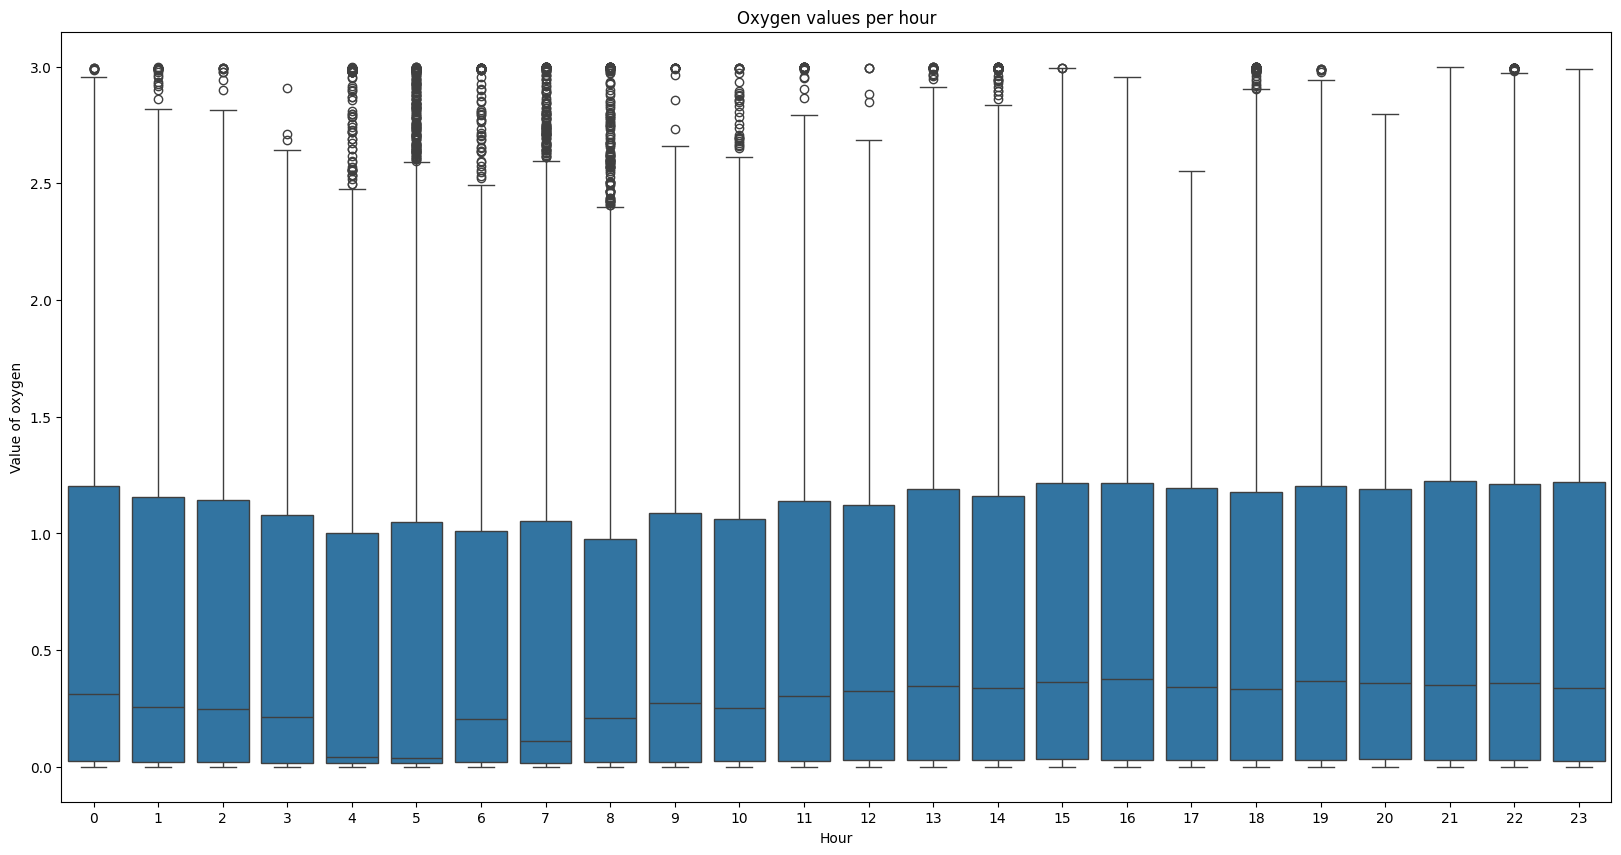

In [101]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df,x='hour',y='oxygenValue')
plt.title('Oxygen values per hour')
plt.xlabel("Hour")
plt.ylabel("Value of oxygen")

Text(0, 0.5, 'Value of oxygen')

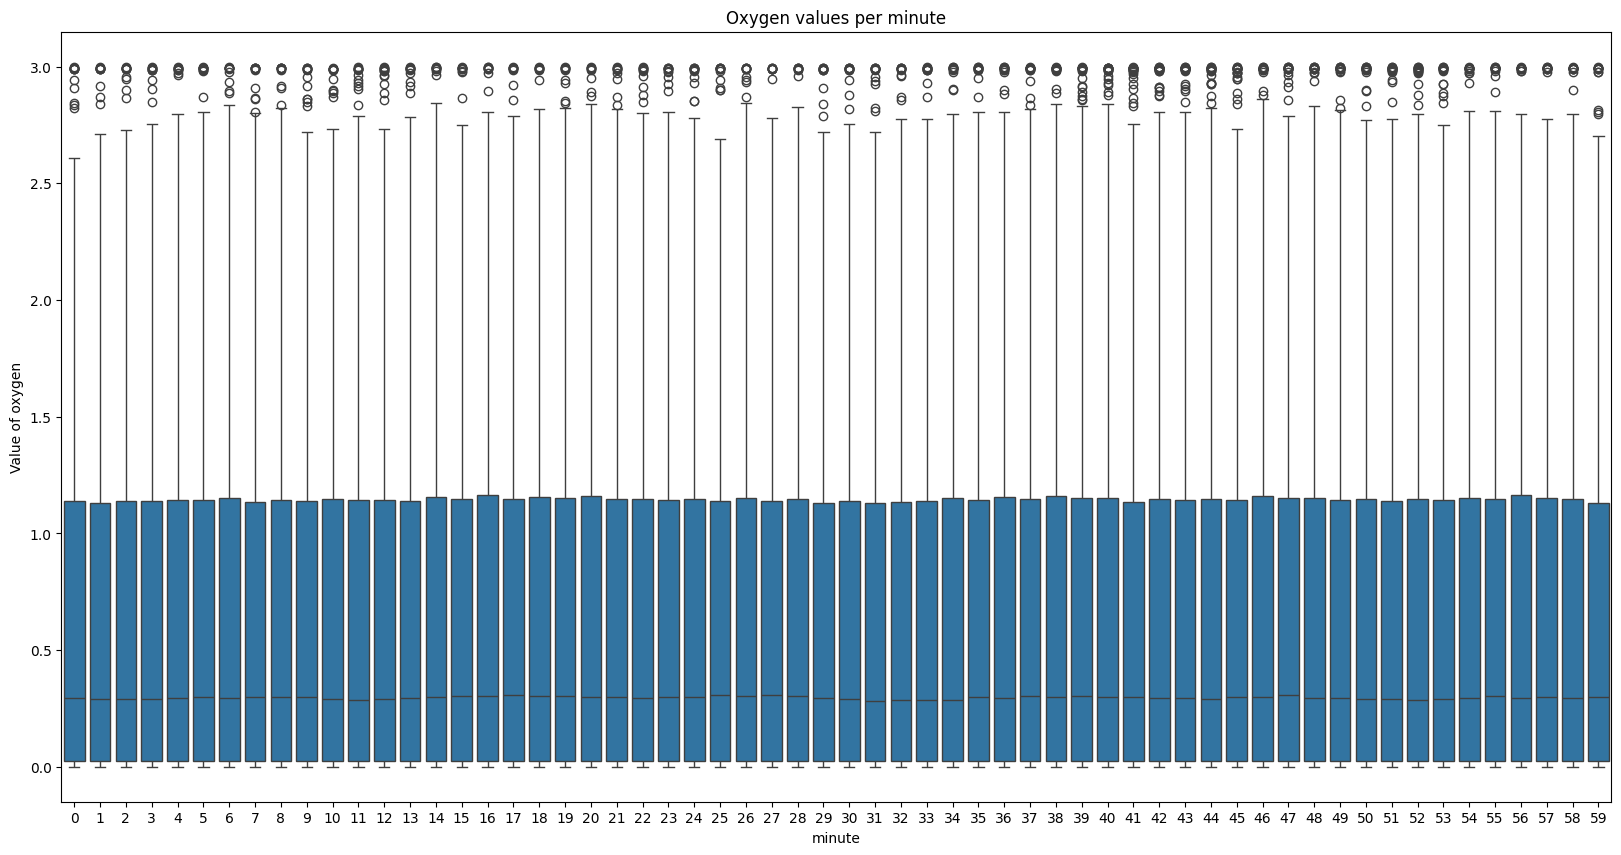

In [102]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df,x='minute',y='oxygenValue')
plt.title('Oxygen values per minute')
plt.xlabel("minute")
plt.ylabel("Value of oxygen")

# Lag Features

In [103]:
target_map = df['oxygenValue'].to_dict()

In [104]:
def add_lags(df):
    df['lag_1']=(df.index - pd.Timedelta('1 day')).map(target_map)
    df['lag_2']=(df.index - pd.Timedelta('2 day')).map(target_map)
    df['lag_3']=(df.index - pd.Timedelta('3 day')).map(target_map)
    return df

In [105]:
df= add_lags(df)


# Creating a model

In [106]:
train = create_features(train)
test = create_features(test)

In [107]:
FEATURES = ['nitrateValue', 'phosphateValue', 'ammoniumValue',
       'waterFlowPerMinute', 'precipitation', 'minute', 'hour', 'dayofweek',
       'quarter', 'month']
TARGET = 'oxygenValue'

In [108]:
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

In [109]:
params = {
    'n_estimators': 5,
    # 'max_depth': 6,
    'learning_rate': 0.0009,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'gamma': 0.0000001,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'tree_method': 'hist',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42,
    'early_stopping_rounds': 50  # You can keep this as it is
}

reg = xgb.XGBRegressor(**params)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:0.68635	validation_1-rmse:0.54212
[4]	validation_0-rmse:0.68544	validation_1-rmse:0.54181


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=1e-07, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0009, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Feature importance

In [110]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

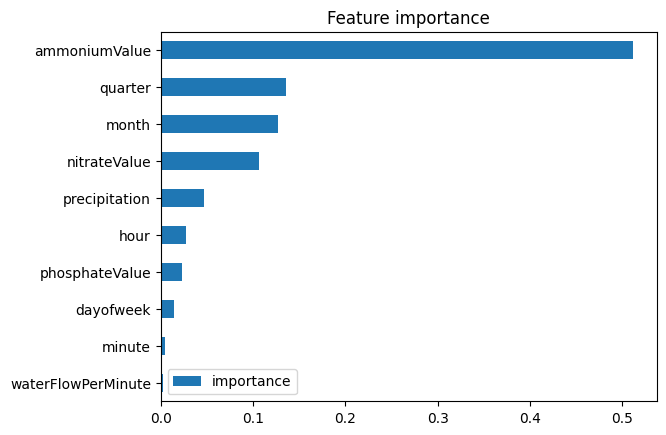

In [111]:
fi.sort_values('importance').plot(kind='barh', title="Feature importance")
plt.show()

In [112]:
test['prediction']=reg.predict(X_test)
df= df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

# Prediction

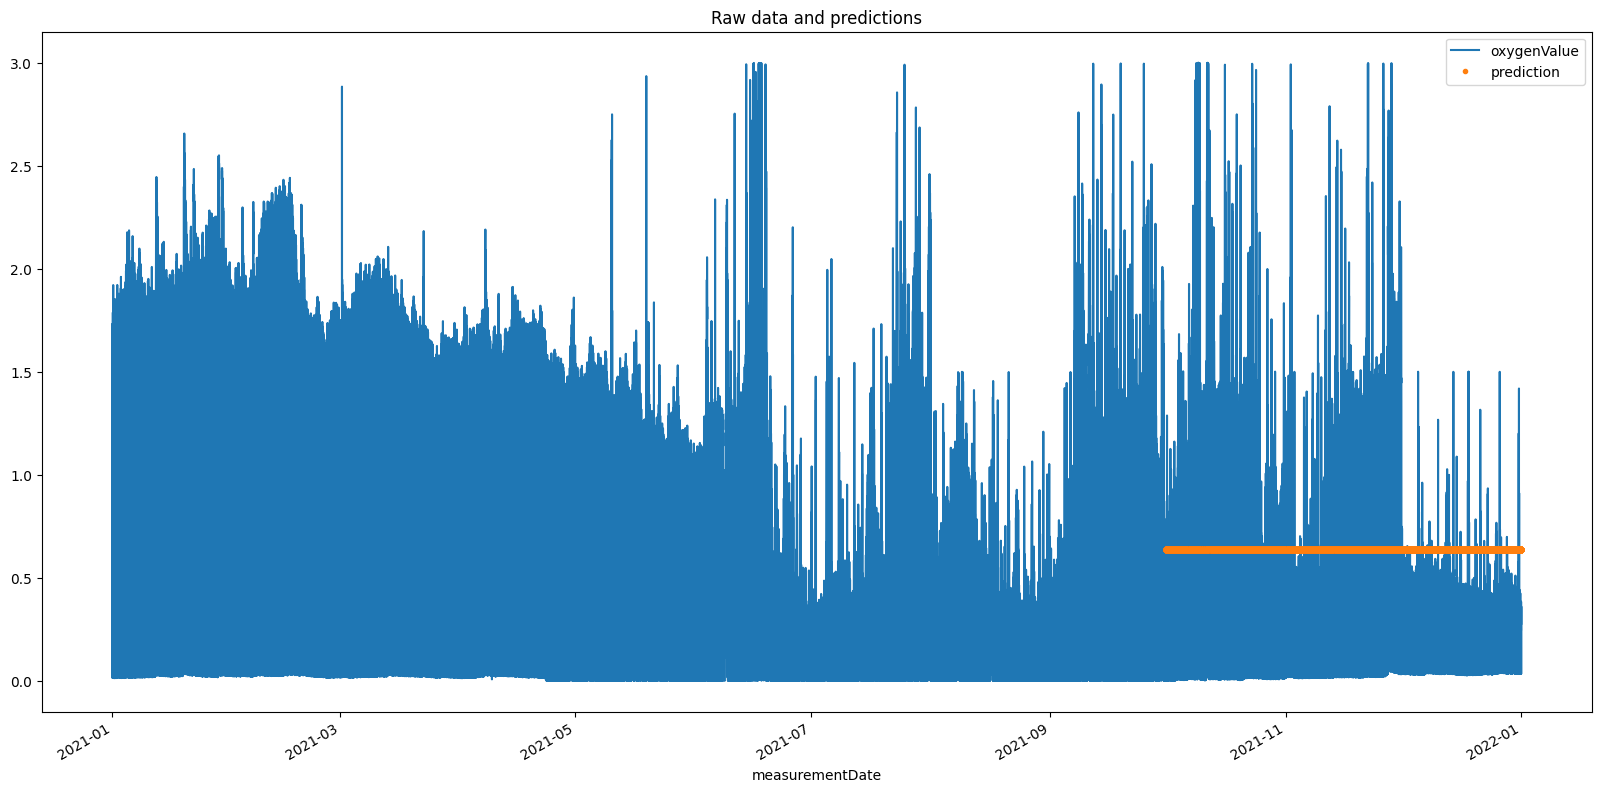

In [113]:
ax = df[['oxygenValue']].plot(figsize=(20,10))
df['prediction'].plot(ax=ax,style='.')
plt.legend()
ax.set_title('Raw data and predictions')
plt.show()

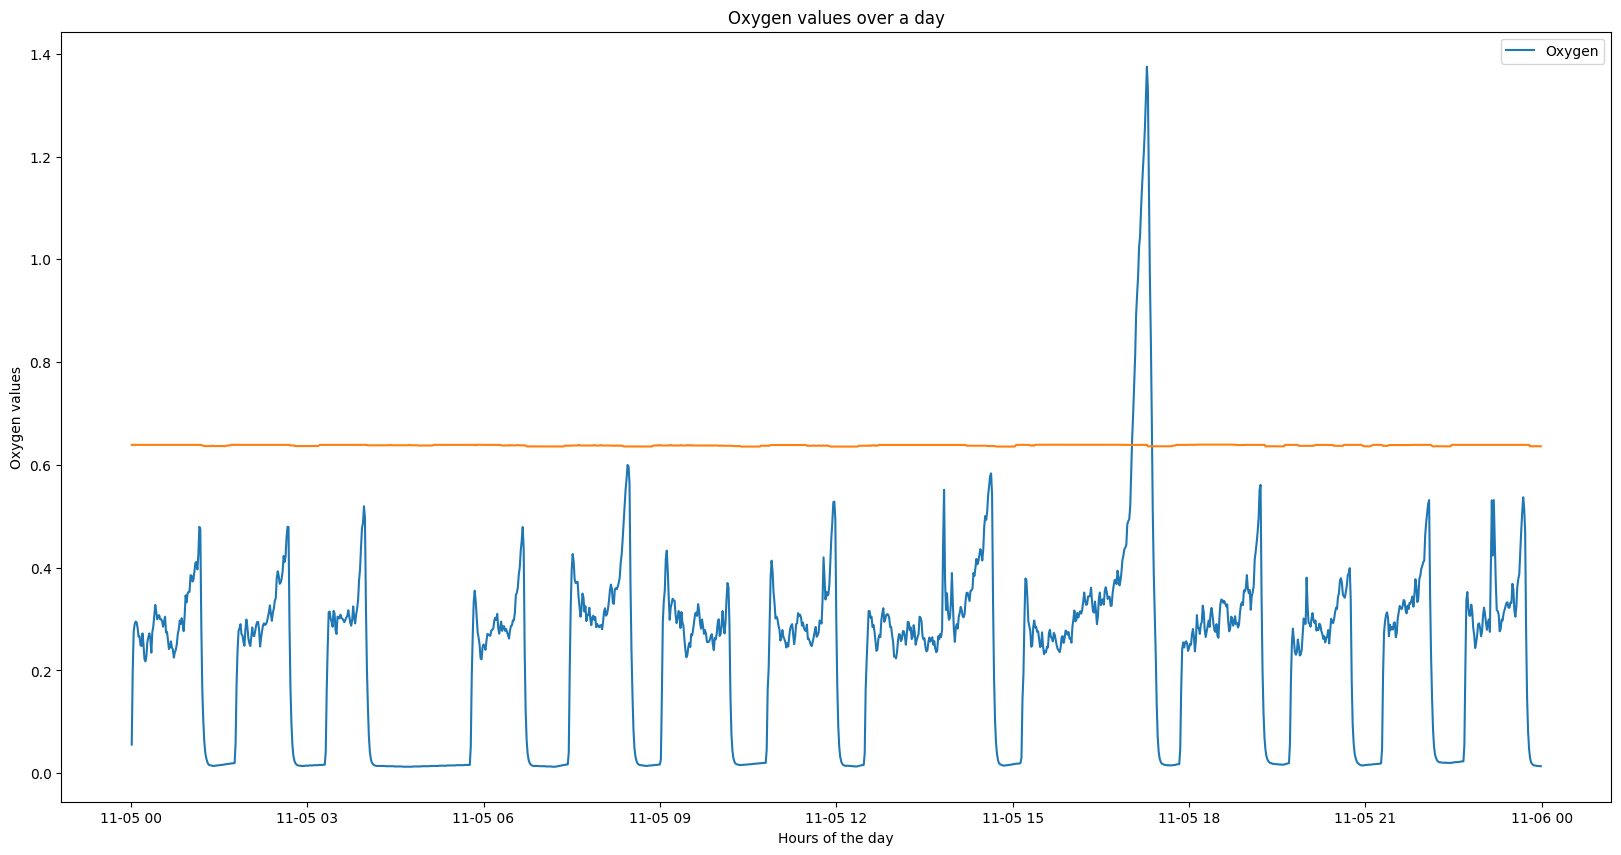

In [114]:
day = df.loc[(df.index > '2021-11-05') & (df.index < '2021-11-06')]

plt.figure(figsize=(20,10))
plt.title("Oxygen values over a day")
plt.plot(day.index,day['oxygenValue'])
plt.plot(day.index,day['prediction'])
plt.xlabel('Hours of the day')
plt.ylabel('Oxygen values')
plt.legend(["Oxygen"])

In [115]:
print(f"The model's Root Mean Squared Error: {root_mean_squared_error(test['oxygenValue'],test['prediction'])}")

The model's Root Mean Squared Error: 0.5418131350239251


# Future prediction

In [116]:
df = pd.read_parquet('../data/cleanedData/allData.parquet')
df.set_index('measurementDate', inplace=True)

In [117]:
tss = TimeSeriesSplit(n_splits=5, test_size=60*24*30, gap=60*24)
df = df.sort_index()

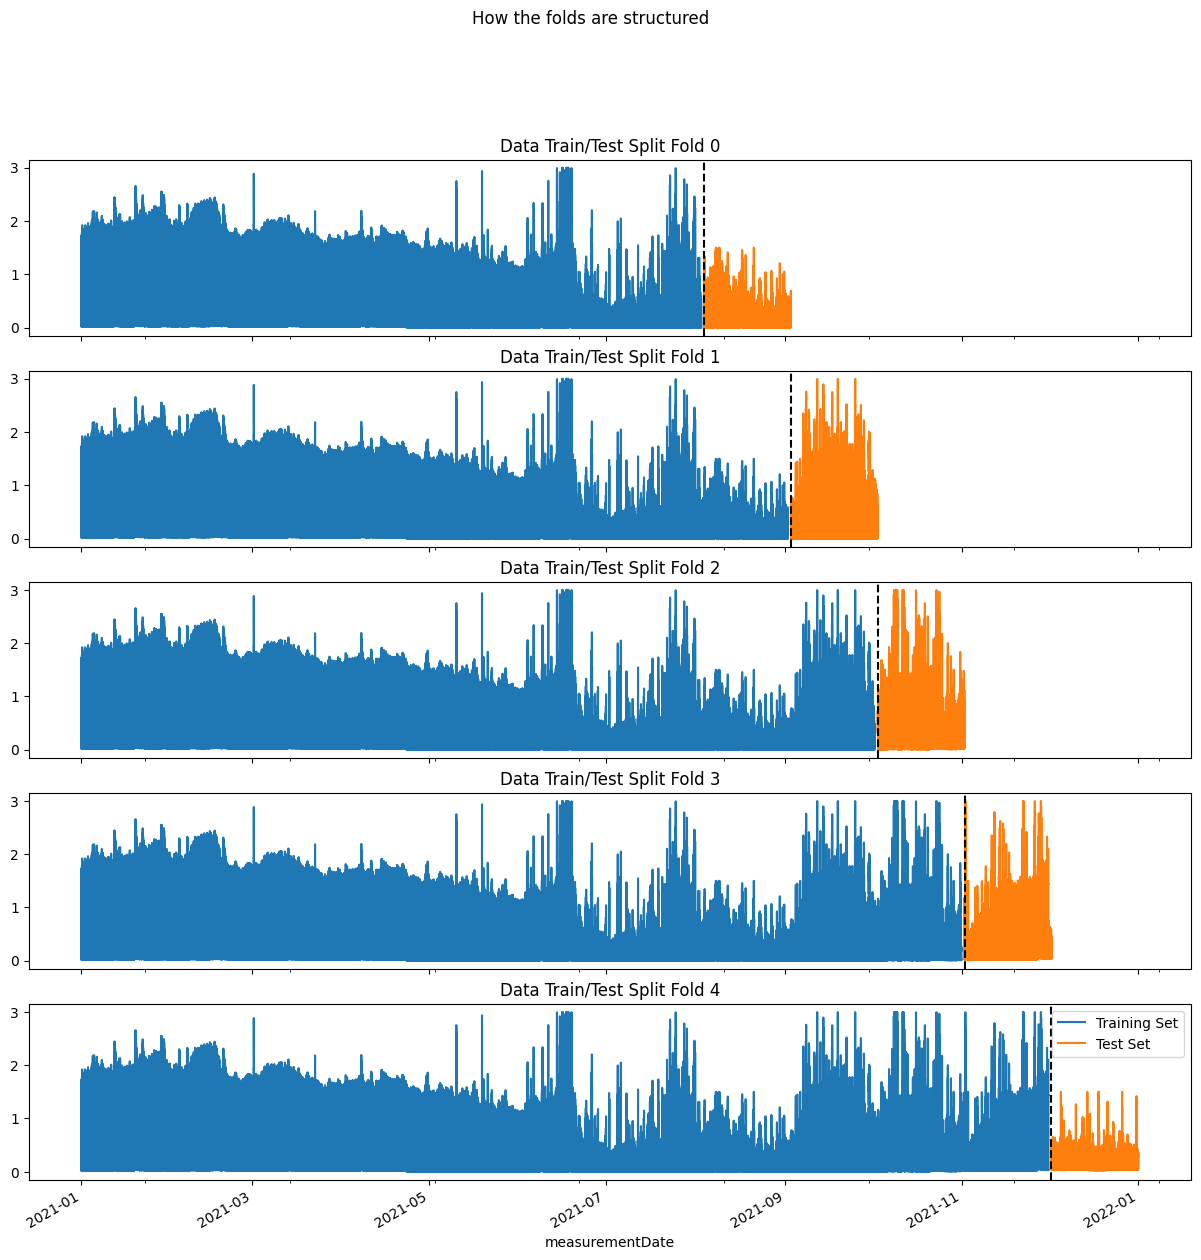

In [118]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train['oxygenValue'].plot(ax=axs[fold], label='Training Set')
    test['oxygenValue'].plot(ax=axs[fold], label='Test Set')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].set_title(f'Data Train/Test Split Fold {fold}')
    
    fold += 1
fig.suptitle('How the folds are structured')
plt.legend()
plt.show()

# Forecasting Horizon:
The forcasting horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long term horizons (more than two years).

For our project we chose the short term prediction of one month

# Future prediction

In [119]:
target_map = df['oxygenValue'].to_dict()

for feature in ['nitrateValue', 'phosphateValue', 'ammoniumValue',]:
    df[feature] = np.log1p(df[feature])

df = create_features(df)
df= add_lags(df)
FEATURES= ['nitrateValue', 'phosphateValue', 'ammoniumValue',
       'waterFlowPerMinute', 'precipitation', 'minute', 'hour', 'dayofweek',
       'quarter', 'month', 'lag_1', 'lag_2', 'lag_3']
TARGET = 'oxygenValue'

In [120]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

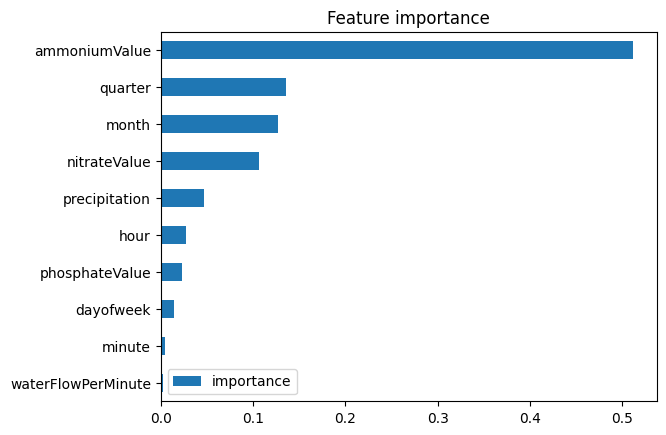

In [121]:
fi.sort_values('importance').plot(kind='barh', title="Feature importance")
plt.show()

In [122]:
fold = 0
preds =[]
scores =[]
r2_scores = []
for train_idx, val_idx in tss.split(df):
    train= df.iloc[train_idx]
    test = df.iloc[val_idx]

    train= create_features(train)
    test = create_features(test)

    scaler = StandardScaler()
    train[FEATURES] = scaler.fit_transform(train[FEATURES])
    test[FEATURES] = scaler.transform(test[FEATURES])

    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.3, booster='gbtree',
                           n_estimators=2000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=6,
                           gamma=0.001,
                           tree_method='auto',
                           learning_rate=0.001)
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = root_mean_squared_error(y_test,y_pred)
    scores.append(score)
    r2= r2_score(y_test,y_pred)
    r2_scores.append(r2)


In [123]:
print(f'Score across folds: {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')
print(f'R2 score across the folds:  {np.mean(r2_scores):0.4f}')
print(f'Fold R2 scores: {r2_scores}')

Fold R2 scores: []
